We'll use the config file generated by 'btviewer' the bee-track viewer software.

In [5]:
import json
data = json.load(open('config_new.json','r'))['items']
for i in range(1,7): 
    if 'cam%d'%i not in data: data['cam%d'%i]={}
data['cam6']['initpos']=[-1,15,0]
data['cam2']['initpos']=[4,15,0]
data['cam3']['initpos']=[15,8,0]
data['cam5']['initpos']=[15,2,0]
data['cam4']['initpos']=[15,-5,0]
data['cam1']['initpos']=[0,-15,0]
json.dump({'items':data},open('config_new.json','w'))

FileNotFoundError: [Errno 2] No such file or directory: 'config_new.json'

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation as R
class Object():
    def __init__(self, name, position=None, orientation=None, fov=None):
        """
            position = position in 3d.
            orientation = [yaw,pitch,roll]
        """
        #self.label = label
        if position is None:
            self.position = np.random.rand(3)*1.0
        else:
            self.position = np.array(position)
            
        self.position[2]=0 #no 3d
        
        #These bits only relevant for cameras (could subclass)
        if orientation is None:
            self.orientation = np.random.rand(3)*np.pi*2
        else:
            self.orientation = np.array(orientation)
        
        self.orientation[1:]=0 #no 3d
        if fov is None:
            self.fov = 0.577*2 #60deg fov
        else:
            self.fov = fov
        self.vfov = np.tan(self.fov/2)*(3/4)
        self.hfov = np.tan(self.fov/2)
        self.observations = []
        self.camera = False
        self.constraints = []
        self.name = name
    def getnumparam(self):
        if self.camera:
            return 3 #6
        else:
            return 2 #3
        
    #def getparams(self):
    #    if self.camera:
    #        return np.r_[self.position,self.orientation]
    #    else:
    #        return self.position
        
    def getparams(self):
        if self.camera:
            return np.r_[self.position[:2],self.orientation[0:1]]
        else:
            return self.position[:2]
        
    def setparams(self,v):
        if self.camera:
            self.orientation = np.array([v[2],0,0]) #v[3:6]
            #self.position = np.array([v[0],v[1],0]) #v[0:3]   #don't change position          
        else:
            self.position = np.array([v[0],v[1],0]) #v[0:3]
        
    def addobservation(self, target, coords):
        self.observations.append({'target':target, 'coords':coords})
        
    def addconstraintdistance(self,target,dist):
        self.constraints.append({'target':target,'dist':dist})
    def getpixel(self, target):
        """
        If this is a camera, then for a target object, get the position of the object in the image
        """
        p = np.array(target.position - self.position)
        r1 = R.from_euler('z', self.orientation[0], degrees=False) #yaw
        r2 = R.from_euler('Y', self.orientation[1], degrees=False) #pitch (intrinsic rotation around y axis)    
        r3 = R.from_euler('X', self.orientation[2], degrees=False) #roll (intrinsic rotation around x axis)    

        pvec = r3.apply(r2.apply(r1.apply(p)))
        if len(pvec.shape)==1:
            pvec = pvec[None,:]
        #1024 x 768 or in our case 2048 x 1536
        #if pvec[:,0]<10:
        #    z = np.log(1+np.exp(pvec[:,0]*2))/2
        #else:
        #    z = pvec[:,0]
        z = pvec[:,0]
        if np.abs(z)<0.0001: z = 0.0001
        if z<0:
            loss = -z
        else:
            loss = 0
        #print(pvec[:,0],z)
        res = np.array([1024+1024*(-pvec[:,1]/z)/self.hfov,(1024+1024*(pvec[:,2]/z/self.vfov))*0.75]).T
        return res, loss

In [4]:
np.set_printoptions(precision=2,suppress=True)

objects = {}
cameras = {}
Ncam = 6
for c in range(1,Ncam+1):
    name = 'cam%d' % c
    if name not in data:
        data[name]={'imgcoords':{}}
    
for item, contents in data.items():
    print("Adding %s" % item)
    if 'initpos' in contents:
        initpos = contents['initpos']
    else:
        initpos = None
    
    obj = Object(item,initpos)
    objects[item] = obj
    if item[:3] == 'cam':
        cameras[item] = obj
        obj.camera=True
        
for item, contents in data.items():
    if 'imgcoords' in contents:
        for cam,coords in contents['imgcoords'].items():
            if item in objects:
                cameras[cam].addobservation(objects[item],coords)
    if 'constraintdistance' in contents:
        for target,dist in contents['constraintdistance'].items():
            objects[item].addconstraintdistance(objects[target],dist)
    
        
for postid in range(16):
    if 'post%dtop' % postid in objects:
        objects['post%dtop' % postid].addconstraintdistance(objects['post%dbottom' % postid],0.568)
                

NameError: name 'np' is not defined

In [179]:
#size of A2 594mm -> 568 from top to bottom of code 0.568

In [180]:

initparams = []
for _,obj in objects.items():
    initparams.append(obj.getparams())
initparams = np.concatenate(initparams)
it = 0
def compute_error(cameras):
    global it
    it+=1
    err = 0
    for camid,camobj in cameras.items():
        for obs in camobj.observations:
            pix,loss = camobj.getpixel(obs['target'])
            err+=np.sum(pix-obs['coords'])**2
            
            #if it % 100==0:
            #    print("<<<",camid,obs['target'].name,pix,obs['coords'])

            err+=loss*100
    
          
    for _,obj in objects.items():    
        for con in obj.constraints:
            #print(obj.name,con['target'].name)
            dist = np.sqrt(np.sum((con['target'].position*100 - obj.position*100)**2))
            #print(dist)
            err+=(dist-con['dist']*100)**2 #converted to cm^2 to have high weight
        err+=np.sum(obj.position**2)*0.1
            
    #print(err)
    return err

def set_params(objects,params):
    n=0
    for _,obj in objects.items():        
        obj.setparams(params[n:])
        n+=obj.getnumparam()
def error_fn(params):
    set_params(objects,params)
    return compute_error(cameras)

In [181]:
compute_error(cameras)

array([1.35e+09])

In [182]:
#initparams = res.x

In [183]:
from scipy.optimize import minimize
import matplotlib.pyplot as plt

def cb(xk):
    print(error_fn(xk),xk)
res = minimize(error_fn,initparams,callback=cb,method='CG',options={'maxiter':200})

[3.15e+08] [  0.13   0.96   0.64   0.42   0.23   0.19   0.5    0.09   0.06   0.3
   0.81   0.74   0.79   0.36   0.53   0.81   0.23   0.79   0.58   0.8
   0.26   0.77   0.91   0.27   0.38   0.54   0.25   0.61   0.96   0.86
   0.47   0.03   0.38   0.8    0.52   0.04   0.52   0.09   0.99   0.91
   0.05   0.66   0.38   0.25   0.16   0.33   0.66   0.81   0.95   0.34
   0.26   1.     0.   -10.     0.74   0.    10.     1.93   0.73   0.41
   5.    10.     4.4    9.     8.     1.27   8.    -3.     4.55  11.
   2.     0.67]
[55790474.45] [  0.14   0.95   0.65   0.41   0.24   0.19   0.51   0.09   0.07   0.3
   0.82   0.74   0.8    0.36   0.54   0.8    0.23   0.79   0.58   0.8
   0.26   0.77   0.91   0.27   0.38   0.55   0.25   0.62   0.95   0.87
   0.47   0.04   0.37   0.81   0.52   0.05   0.53   0.09   1.     0.9
   0.05   0.66   0.38   0.25   0.16   0.34   0.66   0.82   0.95   0.34
   0.26   0.99   0.   -10.     1.24   0.    10.     1.86   0.73   0.41
   5.    10.     4.55   9.     8.     2.35 

[6281147.02] [  0.78   1.42   1.39   0.76   2.25   0.97   1.16   1.1    1.78   1.52
   1.67   2.1    3.64  -1.23   4.47  -1.59   0.29  -0.21   0.65  -0.03
   1.25   0.71   1.89   0.19   0.56   0.24   0.65   0.74  -1.34   2.13
  -2.13   1.49  -3.23   0.19  -2.97  -0.75   2.76  -0.13   3.73  -0.5
   0.05   0.66   0.39   0.25  -2.69   0.29  -2.15   0.64  -1.2    1.32
  -0.65   1.47   0.   -10.     1.51   0.    10.     1.38   0.73   0.41
   5.    10.     4.87   9.     8.     1.85   8.    -3.     3.57  11.
   2.    -0.33]
[4629883.49] [  1.13   1.61   1.72   0.95   1.98   1.24   1.01   1.37   2.63   1.46
   2.24   2.01   4.22  -1.56   5.14  -1.98   0.35  -0.7    0.7   -0.43
   1.71   0.66   2.32   0.13   0.67   0.12   0.86   0.71  -2.06   2.54
  -2.91   1.95  -3.86  -0.15  -3.68  -1.21   4.18  -0.19   5.38  -0.24
   0.04   0.66   0.39   0.24  -3.5    0.2   -3.03   0.71  -2.12   1.88
  -1.05   1.73   0.   -10.     1.52   0.    10.     1.23   0.73   0.41
   5.    10.     4.94   9.     8.     

[1643473.56] [  1.7    2.03   2.22   1.39   1.67   1.28   0.85   1.34   3.72   1.09
   3.28   1.55   4.02  -1.58   4.58  -1.71   0.52  -1.61   0.81  -1.2
   2.5    0.52   3.05  -0.     1.04   0.13   1.35   0.63  -2.6    2.97
  -3.51   2.46  -4.41  -0.33  -4.29  -1.54   6.45  -0.7    6.53  -1.03
   0.04   0.67   0.39   0.24  -4.25   0.2   -4.08   0.84  -3.33   2.92
  -1.83   2.24   0.   -10.     1.49   0.    10.     1.46   0.73   0.41
   5.    10.     4.96   9.     8.     1.79   8.    -3.     3.64  11.
   2.    -0.44]
[1607470.49] [  1.72   2.05   2.24   1.41   1.66   1.27   0.85   1.33   3.75   1.07
   3.32   1.52   3.97  -1.57   4.51  -1.68   0.53  -1.65   0.82  -1.23
   2.53   0.51   3.08  -0.01   1.06   0.13   1.38   0.63  -2.6    2.98
  -3.5    2.48  -4.42  -0.32  -4.29  -1.54   6.5   -0.74   6.6   -1.05
   0.04   0.67   0.39   0.24  -4.26   0.2   -4.11   0.85  -3.37   2.96
  -1.86   2.26   0.   -10.     1.5    0.    10.     1.46   0.73   0.41
   5.    10.     4.95   9.     8.     

[1188425.25] [  2.17   2.64   2.64   2.04   1.58   1.05   0.7    1.07   4.     0.91
   3.62   1.44   3.91  -1.94   4.83  -2.21   0.65  -2.57   0.86  -2.02
   3.18   0.33   3.64  -0.16   1.46   0.03   1.89   0.42  -2.67   3.06
  -3.56   2.62  -4.61  -0.16  -4.47  -1.45   6.48  -1.     6.97  -1.32
   0.04   0.67   0.39   0.24  -4.51   0.33  -4.63   0.84  -3.98   3.88
  -2.63   2.83   0.   -10.     1.51   0.    10.     1.49   0.73   0.41
   5.    10.     4.98   9.     8.     1.8    8.    -3.     3.65  11.
   2.    -0.46]
[1175347.44] [  2.18   2.66   2.65   2.05   1.58   1.05   0.7    1.07   4.     0.91
   3.62   1.44   3.91  -1.95   4.81  -2.21   0.65  -2.58   0.86  -2.03
   3.19   0.32   3.65  -0.16   1.47   0.03   1.89   0.42  -2.67   3.06
  -3.56   2.62  -4.61  -0.16  -4.47  -1.45   6.47  -1.     6.9   -1.35
   0.04   0.67   0.39   0.24  -4.51   0.33  -4.63   0.84  -3.98   3.89
  -2.63   2.83   0.   -10.     1.52   0.    10.     1.49   0.73   0.41
   5.    10.     4.98   9.     8.    

[1058626.05] [  2.53   3.11   2.98   2.55   1.55   1.1    0.69   1.14   3.88   0.93
   3.45   1.41   3.96  -2.31   4.53  -2.41   0.62  -3.03   0.83  -2.45
   3.45   0.23   3.88  -0.24   1.65  -0.15   2.11   0.26  -2.74   2.98
  -3.63   2.57  -4.64  -0.1   -4.49  -1.36   6.34  -0.96   6.69  -1.19
   0.04   0.67   0.4    0.23  -4.55   0.39  -4.8    0.67  -3.91   3.94
  -2.82   2.97   0.   -10.     1.52   0.    10.     1.5    0.73   0.41
   5.    10.     4.98   9.     8.     1.81   8.    -3.     3.63  11.
   2.    -0.47]
[1054943.83] [  2.54   3.12   2.99   2.57   1.55   1.1    0.69   1.14   3.88   0.93
   3.45   1.41   3.95  -2.31   4.53  -2.42   0.62  -3.04   0.83  -2.46
   3.46   0.23   3.88  -0.24   1.66  -0.15   2.12   0.25  -2.74   2.97
  -3.63   2.57  -4.64  -0.1   -4.49  -1.36   6.36  -0.95   6.67  -1.2
   0.04   0.67   0.4    0.23  -4.55   0.39  -4.81   0.67  -3.91   3.94
  -2.82   2.97   0.   -10.     1.52   0.    10.     1.49   0.73   0.41
   5.    10.     4.98   9.     8.     

[987771.72] [  2.81   3.58   3.25   3.08   1.5    1.12   0.63   1.18   3.93   0.89
   3.51   1.42   3.65  -2.39   4.62  -2.73   0.57  -3.33   0.77  -2.73
   3.57   0.18   3.99  -0.28   1.75  -0.17   2.2    0.21  -2.76   2.92
  -3.66   2.51  -4.63  -0.11  -4.48  -1.37   6.4   -1.06   6.78  -1.48
   0.04   0.67   0.4    0.23  -4.55   0.37  -4.94   0.57  -3.91   4.03
  -2.83   2.95   0.   -10.     1.52   0.    10.     1.5    0.73   0.41
   5.    10.     4.98   9.     8.     1.81   8.    -3.     3.63  11.
   2.    -0.48]
[985604.8] [  2.81   3.58   3.26   3.08   1.5    1.12   0.63   1.17   3.93   0.89
   3.51   1.42   3.65  -2.4    4.61  -2.73   0.57  -3.33   0.77  -2.73
   3.57   0.18   3.99  -0.28   1.75  -0.17   2.2    0.21  -2.76   2.92
  -3.66   2.51  -4.63  -0.11  -4.48  -1.37   6.4   -1.06   6.79  -1.47
   0.04   0.67   0.4    0.23  -4.55   0.37  -4.94   0.57  -3.91   4.03
  -2.83   2.95   0.   -10.     1.52   0.    10.     1.5    0.73   0.41
   5.    10.     4.98   9.     8.     1.

[920265.44] [  3.16   3.88   3.6    3.46   1.51   1.13   0.65   1.18   3.88   0.87
   3.45   1.36   3.81  -2.66   4.33  -2.8    0.55  -3.55   0.74  -2.93
   3.62   0.15   4.03  -0.29   1.79  -0.24   2.24   0.15  -2.78   2.85
  -3.67   2.45  -4.63  -0.15  -4.46  -1.41   6.4   -1.03   6.78  -1.26
   0.04   0.67   0.4    0.23  -4.52   0.32  -5.     0.47  -3.86   4.03
  -2.84   2.94   0.   -10.     1.53   0.    10.     1.49   0.73   0.41
   5.    10.     4.97   9.     8.     1.82   8.    -3.     3.63  11.
   2.    -0.49]
[918585.32] [  3.17   3.89   3.61   3.48   1.51   1.13   0.65   1.18   3.88   0.87
   3.44   1.36   3.81  -2.66   4.33  -2.8    0.55  -3.56   0.74  -2.94
   3.62   0.15   4.04  -0.29   1.79  -0.24   2.24   0.15  -2.78   2.85
  -3.67   2.45  -4.63  -0.15  -4.46  -1.41   6.38  -1.04   6.78  -1.26
   0.04   0.67   0.4    0.23  -4.52   0.32  -5.     0.46  -3.85   4.03
  -2.84   2.94   0.   -10.     1.53   0.    10.     1.5    0.73   0.41
   5.    10.     4.97   9.     8.     1

[883325.09] [  3.34   4.16   3.8    3.79   1.51   1.13   0.64   1.19   3.88   0.85
   3.44   1.36   3.64  -2.7    4.43  -2.99   0.53  -3.69   0.73  -3.07
   3.65   0.14   4.06  -0.3    1.81  -0.26   2.26   0.12  -2.79   2.81
  -3.68   2.41  -4.6   -0.19  -4.43  -1.45   6.4   -1.07   6.77  -1.42
   0.04   0.67   0.4    0.23  -4.48   0.27  -5.03   0.39  -3.81   4.01
  -2.81   2.91   0.   -10.     1.53   0.    10.     1.5    0.73   0.41
   5.    10.     4.97   9.     8.     1.82   8.    -3.     3.62  11.
   2.    -0.49]
[882649.26] [  3.35   4.17   3.8    3.8    1.51   1.13   0.64   1.19   3.88   0.85
   3.44   1.36   3.64  -2.7    4.43  -2.99   0.53  -3.69   0.72  -3.07
   3.65   0.14   4.06  -0.3    1.81  -0.26   2.26   0.12  -2.79   2.8
  -3.68   2.4   -4.6   -0.19  -4.43  -1.45   6.4   -1.07   6.78  -1.42
   0.04   0.67   0.4    0.23  -4.48   0.27  -5.03   0.38  -3.81   4.01
  -2.81   2.91   0.   -10.     1.53   0.    10.     1.49   0.73   0.41
   5.    10.     4.97   9.     8.     1.

[832851.86] [  3.71   4.53   4.19   4.28   1.52   1.13   0.65   1.19   3.85   0.81
   3.4    1.32   3.63  -2.9    4.3   -3.17   0.51  -3.93   0.7   -3.3
   3.69   0.12   4.11  -0.31   1.85  -0.34   2.3    0.05  -2.78   2.7
  -3.67   2.31  -4.54  -0.29  -4.36  -1.54   6.42  -1.1    6.82  -1.41
   0.04   0.67   0.4    0.23  -4.4    0.16  -5.05   0.23  -3.71   3.96
  -2.74   2.84   0.   -10.     1.53   0.    10.     1.49   0.73   0.41
   5.    10.     4.96   9.     8.     1.83   8.    -3.     3.62  11.
   2.    -0.5 ]
[831948.74] [  3.72   4.55   4.2    4.29   1.52   1.13   0.66   1.19   3.85   0.8
   3.4    1.32   3.63  -2.9    4.31  -3.18   0.51  -3.94   0.7   -3.31
   3.69   0.12   4.11  -0.31   1.85  -0.34   2.3    0.05  -2.78   2.7
  -3.67   2.3   -4.54  -0.29  -4.36  -1.54   6.41  -1.1    6.8   -1.42
   0.04   0.67   0.4    0.23  -4.4    0.15  -5.05   0.22  -3.71   3.95
  -2.74   2.84   0.   -10.     1.53   0.    10.     1.49   0.73   0.41
   5.    10.     4.96   9.     8.     1.83 

[798470.43] [  4.26   4.99   4.79   4.9    1.61   1.09   0.75   1.15   3.81   0.68
   3.34   1.2    3.55  -3.24   4.24  -3.61   0.51  -4.41   0.69  -3.76
   3.78   0.06   4.21  -0.35   1.93  -0.51   2.38  -0.12  -2.72   2.44
  -3.6    2.04  -4.33  -0.57  -4.13  -1.8    6.45  -1.16   6.87  -1.5
   0.04   0.67   0.4    0.23  -4.13  -0.16  -4.98  -0.15  -3.45   3.76
  -2.5    2.64   0.   -10.     1.54   0.    10.     1.47   0.73   0.41
   5.    10.     4.93   9.     8.     1.83   8.    -3.     3.6   11.
   2.    -0.52]
[797723.54] [  4.27   5.     4.81   4.91   1.61   1.08   0.75   1.15   3.81   0.68
   3.34   1.2    3.56  -3.25   4.23  -3.61   0.51  -4.42   0.69  -3.77
   3.79   0.06   4.21  -0.35   1.93  -0.51   2.38  -0.13  -2.71   2.43
  -3.59   2.04  -4.33  -0.58  -4.13  -1.81   6.44  -1.17   6.88  -1.5
   0.04   0.67   0.4    0.23  -4.12  -0.17  -4.98  -0.16  -3.44   3.75
  -2.5    2.63   0.   -10.     1.54   0.    10.     1.47   0.73   0.41
   5.    10.     4.93   9.     8.     1.8

[778858.56] [  4.28   4.98   4.73   4.8    1.74   0.96   0.88   1.02   3.86   0.53
   3.39   1.02   3.63  -3.54   4.14  -3.86   0.52  -4.76   0.7   -4.1
   3.88   0.01   4.31  -0.39   2.02  -0.65   2.46  -0.27  -2.62   2.2
  -3.49   1.8   -4.12  -0.82  -3.91  -2.03   6.53  -1.32   6.89  -1.6
   0.04   0.67   0.4    0.23  -3.88  -0.43  -4.85  -0.45  -3.25   3.61
  -2.29   2.48   0.   -10.     1.55   0.    10.     1.46   0.73   0.41
   5.    10.     4.91   9.     8.     1.82   8.    -3.     3.58  11.
   2.    -0.54]
[775557.34] [  4.3    4.94   4.75   4.77   1.74   0.95   0.89   1.01   3.86   0.52
   3.39   1.02   3.62  -3.55   4.17  -3.89   0.52  -4.77   0.7   -4.12
   3.88   0.01   4.31  -0.39   2.02  -0.66   2.46  -0.28  -2.61   2.19
  -3.48   1.79  -4.11  -0.83  -3.9   -2.05   6.54  -1.31   6.88  -1.63
   0.04   0.67   0.4    0.23  -3.87  -0.45  -4.85  -0.46  -3.24   3.61
  -2.28   2.48   0.   -10.     1.55   0.    10.     1.45   0.73   0.41
   5.    10.     4.91   9.     8.     1.82

[769018.07] [  4.25   4.89   4.76   4.69   1.77   0.9    0.91   0.96   3.89   0.49
   3.42   0.99   3.58  -3.55   4.24  -3.94   0.53  -4.8    0.71  -4.15
   3.9   -0.     4.33  -0.4    2.04  -0.69   2.48  -0.31  -2.6    2.16
  -3.46   1.75  -4.09  -0.85  -3.88  -2.07   6.5   -1.34   6.93  -1.66
   0.04   0.67   0.4    0.23  -3.86  -0.47  -4.83  -0.47  -3.24   3.62
  -2.27   2.5    0.   -10.     1.55   0.    10.     1.45   0.73   0.41
   5.    10.     4.91   9.     8.     1.81   8.    -3.     3.58  11.
   2.    -0.54]
[768937.25] [  4.25   4.88   4.76   4.69   1.77   0.9    0.91   0.96   3.89   0.49
   3.42   0.99   3.58  -3.55   4.24  -3.94   0.53  -4.8    0.71  -4.15
   3.9   -0.     4.33  -0.4    2.04  -0.69   2.48  -0.31  -2.59   2.15
  -3.46   1.75  -4.09  -0.85  -3.88  -2.07   6.5   -1.34   6.93  -1.66
   0.04   0.67   0.4    0.23  -3.86  -0.47  -4.82  -0.48  -3.24   3.62
  -2.27   2.5    0.   -10.     1.55   0.    10.     1.45   0.73   0.41
   5.    10.     4.91   9.     8.     1

[764979.] [  4.25   4.8    4.73   4.65   1.79   0.85   0.93   0.9    3.92   0.45
   3.44   0.95   3.63  -3.61   4.21  -3.94   0.54  -4.85   0.73  -4.2
   3.93  -0.01   4.36  -0.41   2.06  -0.72   2.5   -0.34  -2.57   2.1
  -3.44   1.7   -4.06  -0.89  -3.84  -2.1    6.54  -1.36   6.95  -1.67
   0.04   0.67   0.4    0.23  -3.83  -0.5   -4.8   -0.51  -3.23   3.62
  -2.26   2.51   0.   -10.     1.56   0.    10.     1.44   0.73   0.41
   5.    10.     4.91   9.     8.     1.81   8.    -3.     3.58  11.
   2.    -0.55]
[764954.76] [  4.25   4.8    4.73   4.65   1.79   0.85   0.93   0.9    3.92   0.45
   3.44   0.95   3.63  -3.61   4.21  -3.94   0.54  -4.85   0.73  -4.2
   3.93  -0.01   4.36  -0.41   2.06  -0.72   2.5   -0.34  -2.57   2.1
  -3.44   1.7   -4.06  -0.89  -3.84  -2.1    6.54  -1.36   6.95  -1.67
   0.04   0.67   0.4    0.23  -3.83  -0.5   -4.8   -0.51  -3.23   3.62
  -2.26   2.51   0.   -10.     1.56   0.    10.     1.44   0.73   0.41
   5.    10.     4.91   9.     8.     1.81   

In [184]:

set_params(objects,res.x)

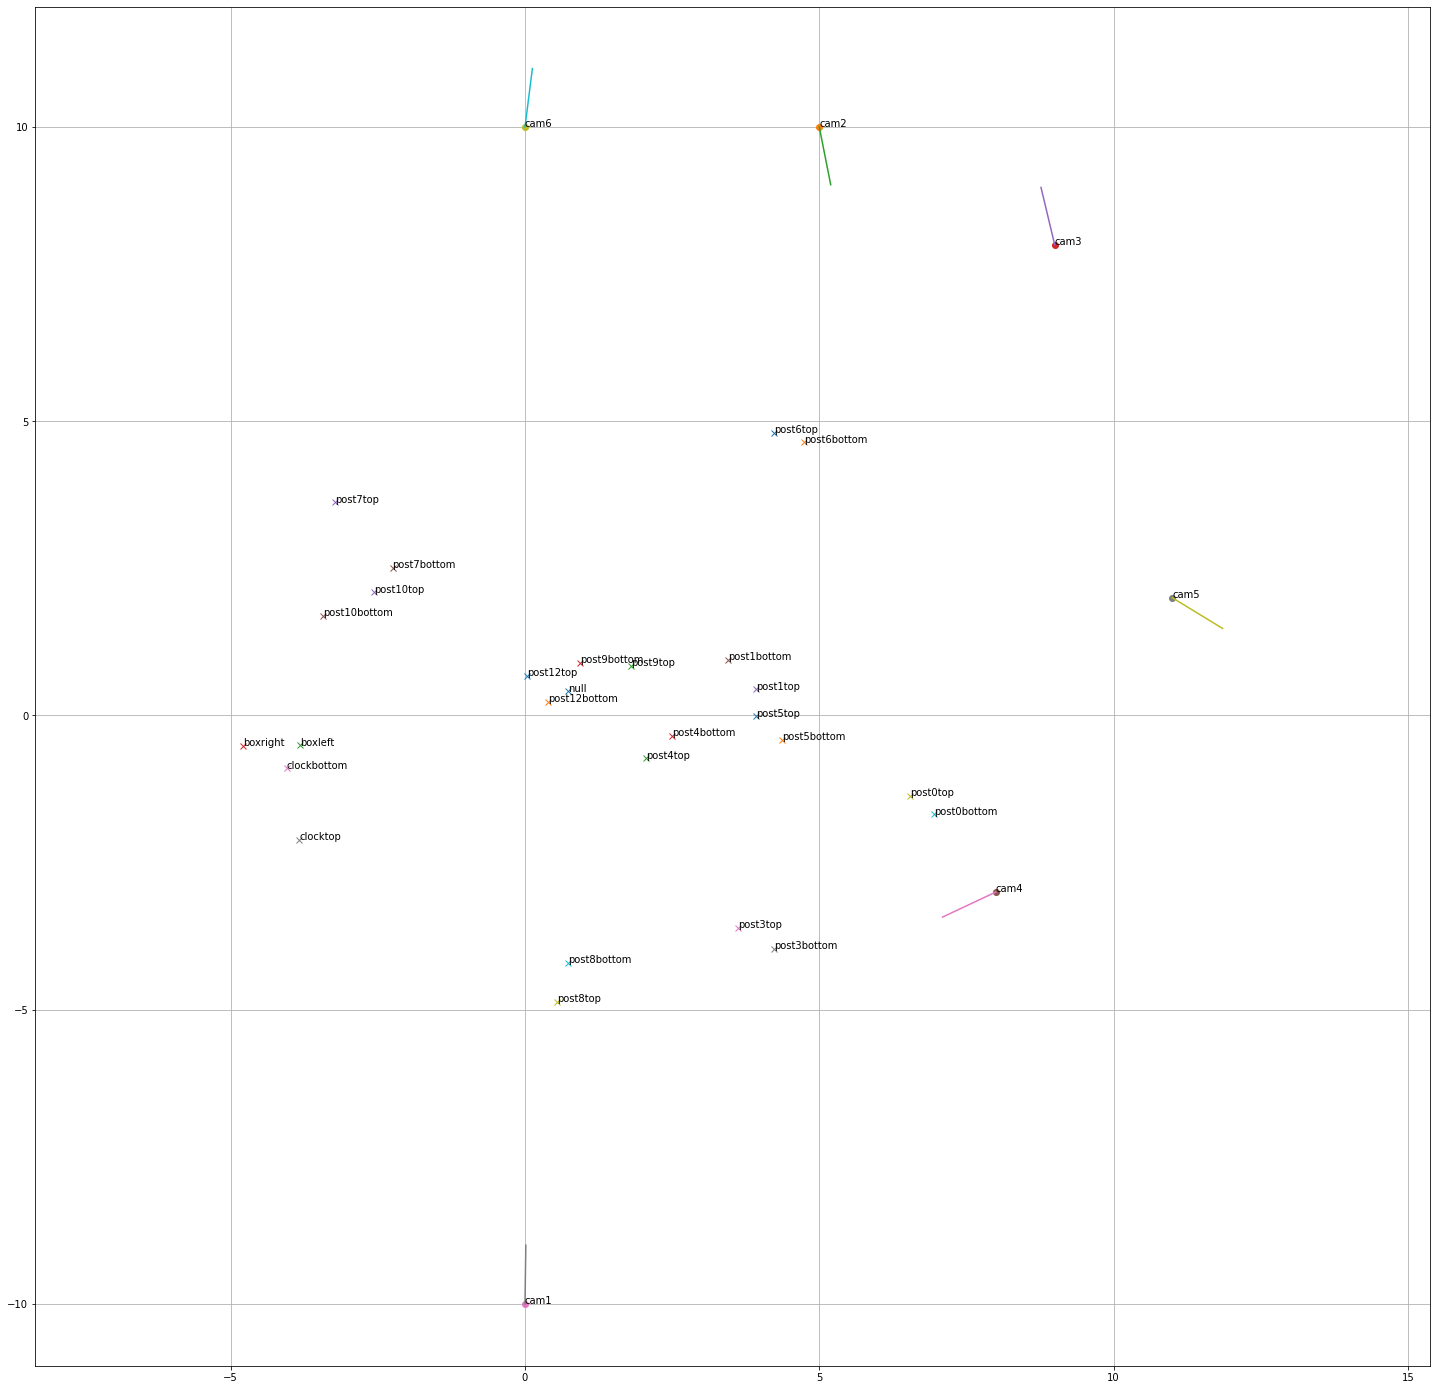

In [185]:
import matplotlib.pyplot as plt
minv = -15
maxv= 22
%matplotlib inline
plt.figure(figsize=[25,25])
for objid,obj in objects.items():
    plt.plot(obj.position[0],obj.position[1],'o' if obj.name[:3]=='cam' else 'x')
    if obj.name[:3]=='cam':
        plt.plot([obj.position[0],obj.position[0]+np.cos(obj.orientation[0])],[obj.position[1],obj.position[1]+np.sin(obj.orientation[0])],'-')
        #if objid[:3]=='cam':
        #if np.all(obj.position[:2]>minv) and np.all(obj.position[:2]<maxv):

    plt.text(obj.position[0],obj.position[1],objid)
plt.axis('equal')
#plt.xlim([minv,maxv])
#plt.ylim([minv,maxv])
plt.grid()

In [109]:
simpos
for objid,obj in simpos.items():
    plt.plot(obj[0],obj[1],'o' if objid[:3]=='cam' else 'x')
    plt.text(obj[0],obj[1],objid)
    #if objid[:3]=='cam':
    #    plt.plot([obj.position[0],obj.position[0]+0.1*np.cos(obj.orientation[0])],[obj.position[1],obj.position[1]+0.1*np.sin(obj.orientation[0])],'-')

NameError: name 'simpos' is not defined

In [192]:
objects['a'].position-objects['b'].position,objects['c'].position-objects['b'].position

KeyError: 'a'

In [193]:
cameras['cam1'].getpixel(cameras['cam2'])

(array([[1440.99,  768.  ]]), array([19.93]))

In [287]:
    campos = {}
    for objid, contents in data.items():
        if objid[:3]=='cam':
            campos[objid] = contents['initpos']
            camangs[objid]=0

    angles = {}
    for objid, contents in data.items():
        if 'imgcoords' not in contents: continue
        for cam, coords in contents['imgcoords'].items():
            if cam not in angles: angles[cam]={}
            angles[cam][objid]=np.tan(-0.4*(coords[0]-1024)/1024)

In [301]:
lstyles = {}
lws = {}
lw = 1
styles = ['-','--',':','.-']
colours = ['r','g','b','k','y']
s = 0
c = 0
for objid, contents in data.items():
    lstyles[objid] = '%s%s' % (styles[s],colours[c])
    lws[objid] = lw
    c+=1
    if c>4:
        c=0
        s+=1
    if s>3:
        s=0
        lw += 2

In [302]:
target

'boxright'

In [303]:
data

{'post6top': {'imgcoords': {'cam1': [1124, 902],
   'cam2': [571, 1065],
   'cam3': [1812, 1420]}},
 'post6bottom': {'imgcoords': {'cam1': [1212, 919],
   'cam2': [453, 1055],
   'cam3': [1612, 1408]}},
 'post9top': {'imgcoords': {'cam1': [1148, 968],
   'cam2': [812, 992],
   'cam3': [1506, 1354],
   'cam4': [925, 1055],
   'cam6': [636, 1181]}},
 'post9bottom': {'imgcoords': {'cam1': [1014, 973],
   'cam2': [1001, 990],
   'cam3': [1630, 1352],
   'cam4': [841, 1047],
   'cam6': [755, 1189]}},
 'post1top': {'imgcoords': {'cam1': [1521, 999],
   'cam5': [1340, 1055],
   'cam3': [1052, 1345],
   'cam4': [1055, 1110]}},
 'post1bottom': {'imgcoords': {'cam1': [1423, 977],
   'cam5': [1495, 1037],
   'cam3': [1176, 1351],
   'cam4': [1099, 1083]}},
 'post3top': {'imgcoords': {'cam1': [1628, 1200],
   'cam5': [627, 1059],
   'cam3': [955, 1301],
   'cam2': [750, 965]}},
 'post3bottom': {'imgcoords': {'cam1': [1833, 1218],
   'cam5': [538, 1092],
   'cam3': [838, 1295],
   'cam2': [638, 966

(-7.0, 15.0)

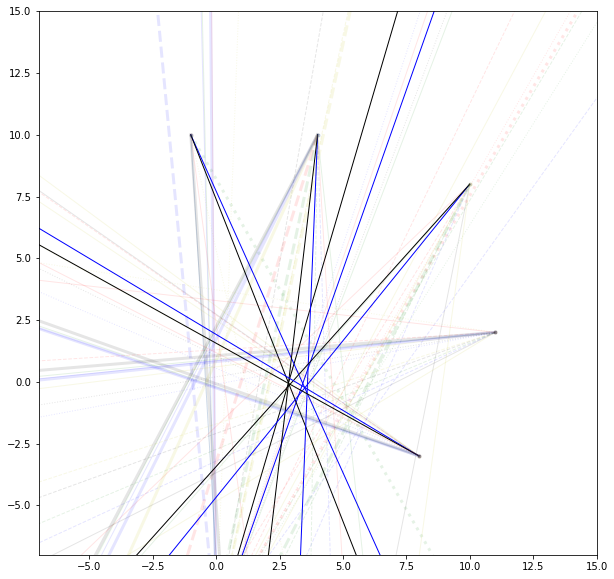

In [325]:
camangs = {'cam1':np.pi*0.41,'cam2':np.pi*1.461,'cam3':np.pi*1.348,'cam4':np.pi-0.59,'cam5':np.pi+0.25,'cam6':-1.31}
plt.figure(figsize=[10,10])
for objid,pos in campos.items():
    for target,angle in angles[objid].items():
        if 'post9' in target:
            a = 1
        else:
            a = 0.1

        #print("(%s)" % target)
        angle = camangs[objid]+angle
        plt.plot([pos[0],pos[0]+np.cos(angle)*100],[pos[1],pos[1]+np.sin(angle)*100],lstyles[target],lw=lws[target],alpha=a)
plt.xlim([-7,15])
plt.ylim([-7,15])
#plt.axis('equal')